In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/DF_PYSPARk_BDTT.ipynb', name='DF_PYSPARk_BDTT.ipynb', size=33691, modificationTime=1651069762000),
 FileInfo(path='dbfs:/FileStore/tables/Hive_PYSPARk_BDTT.sql', name='Hive_PYSPARk_BDTT.sql', size=2298, modificationTime=1651069762000),
 FileInfo(path='dbfs:/FileStore/tables/RDD_Pyspark_BDTT-1.ipynb', name='RDD_Pyspark_BDTT-1.ipynb', size=57413, modificationTime=1651069763000),
 FileInfo(path='dbfs:/FileStore/tables/RDD_Pyspark_BDTT.ipynb', name='RDD_Pyspark_BDTT.ipynb', size=57413, modificationTime=1651069692000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1647956234000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645027718000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip/', name='activations.zip/'

IMPRORTING THE CLINICALTRIAL, PHARMA AND MESH FILES FOR MORE ANALYSIS

In [0]:
clinicaltrial= ('dbfs:/FileStore/tables/clinicaltrial_2021.csv')
pharma= ('dbfs:/FileStore/tables/pharma.csv')
mesh= ('dbfs:/FileStore/tables/mesh.csv')

In [0]:
Clinical_Trial = sc.textFile(clinicaltrial)
header = Clinical_Trial.first()
Main_Clinical_Trial = Clinical_Trial.filter(lambda x: x != header)

In [0]:
Main_Pharma = sc.textFile(pharma)
header = Main_Pharma.first()
Main_Pharma_RDD = Main_Pharma.filter(lambda x: x != header).mapPartitions(lambda x: csv.reader(x))

In [0]:
import csv
Mesh_Rdd = sc.textFile(mesh)
header = Mesh_Rdd.first()
Main_Mesh_Rdd = Mesh_Rdd.filter(lambda x: x != header).mapPartitions(lambda x: csv.reader(x))

PROBLEM 1

In [0]:
Problem1 = Main_Clinical_Trial.map(lambda x: x.split('|'))
Problem1.count()

Out[8]: 387262

PROBLEM 2

In [0]:
rdd3 = Problem1.map(lambda x: (x[5], 1))
rdd4 = rdd3.reduceByKey(lambda x,y: x+y)
rdd5= rdd4.map(lambda x: (x[1], x[0]))
rdd6= rdd5.sortByKey(False)
Problem2 = rdd6.filter(lambda x: x[1] != "")
Problem2.take(5)

Out[9]: [(301472, 'Interventional'),
 (77540, 'Observational'),
 (8180, 'Observational [Patient Registry]'),
 (69, 'Expanded Access'),
 (1, 'Type')]

PROBLEM 3

In [0]:
Problem3 = Problem1.filter(lambda x: x[7] != "").map(lambda x: (x[0], x[7].split(","))).flatMapValues(lambda x: x).map(lambda x: (x[1].strip(), 1)).reduceByKey(lambda x,y: x+y).map(lambda x: (x[1], x[0])).sortByKey(False).filter(lambda x: x[1] != "")

In [0]:
Problem3.take(5)

Out[11]: [(13389, 'Carcinoma'),
 (11080, 'Diabetes Mellitus'),
 (9371, 'Neoplasms'),
 (8640, 'Breast Neoplasms'),
 (8032, 'Syndrome')]

PROBLEM 4

In [0]:
Mesh = Main_Mesh_Rdd.map(lambda x: (x[0].strip(), x[1].split(".")[0])).map(lambda x: (x[0], x[1])).groupByKey().map(lambda x: (x[0], list(x[1])))

In [0]:
Clinical = Problem1.map(lambda x: (x[0], x[7].split(","))).flatMapValues(lambda x: x).filter(lambda x: x[1] != '').map(lambda x: (x[1].strip(), x[0])).map(lambda x: (x[0], x[1]))

In [0]:
Clinical_Mesh = Clinical.join(Mesh)
C=Clinical_Mesh.map(lambda x: (x[1][0], x[1][1])).flatMapValues(lambda x: x).map(lambda x: (x[1], 1)).reduceByKey(lambda x,y: x+y).map(lambda x: (x[1], x[0])).sortByKey(False)

In [0]:
C.take(10)

Out[15]: [(143994, 'C04'),
 (136079, 'C23'),
 (106674, 'C01'),
 (94523, 'C14'),
 (92310, 'C10'),
 (85646, 'C06'),
 (70720, 'C08'),
 (42599, 'C13'),
 (41276, 'C18'),
 (40161, 'C12')]

Problem 5

In [0]:
P = Main_Pharma_RDD.map(lambda x: x[1].strip())

In [0]:
Problem5 = set(P.collect())
Problem1.map(lambda x: (x[1].strip(), x[0])).filter(lambda x: x[0] not in Problem5).groupByKey().map(lambda x: (len(x[1]), x[0])).sortByKey(False).take(10)

Out[18]: [(3218, 'National Cancer Institute (NCI)'),
 (2414, 'M.D. Anderson Cancer Center'),
 (2369, 'Assistance Publique - Hôpitaux de Paris'),
 (2300, 'Mayo Clinic'),
 (2243, 'Merck Sharp & Dohme Corp.'),
 (2154, 'Assiut University'),
 (2088, 'Novartis Pharmaceuticals'),
 (1971, 'Massachusetts General Hospital'),
 (1928, 'Cairo University'),
 (1828, 'Hoffmann-La Roche')]

Problem 6

In [0]:
Problem6 = Problem1.filter(lambda x: x[2] == 'Completed').filter(lambda x: x[4] != '').map(lambda x: x[4].split()).filter(lambda x: x[1] == '2021').map(lambda x: (x[0], x[1])).groupByKey().map(lambda x: (x[0], len(x[1])))

In [0]:
Problem6.collect()

Out[20]: [('May', 984),
 ('Jan', 1131),
 ('Jun', 1094),
 ('Mar', 1227),
 ('Feb', 934),
 ('Aug', 700),
 ('Apr', 967),
 ('Jul', 819),
 ('Oct', 187),
 ('Sep', 528)]

ANALYTIC VISUALIZATION

In [0]:
frequency = dict(Problem6.collect())
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
visualization = []
for m in months:
  f = (m, frequency[m])
  visualization.append(f)
  
print(visualization)

[('Jan', 1131), ('Feb', 934), ('Mar', 1227), ('Apr', 967), ('May', 984), ('Jun', 1094), ('Jul', 819), ('Aug', 700), ('Sep', 528), ('Oct', 187)]


In [0]:
rdd = sc.parallelize(visualization)

In [0]:
rdd.collect()

Out[24]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

Out[25]: ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

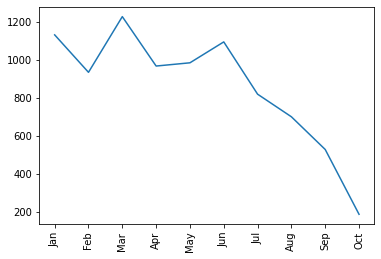

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

x = rdd.map(lambda x: x[0]).collect()
y = rdd.map(lambda x: x[1]).collect()

plt.plot(x, y)
plt.xticks(rotation = 90)